# MNIST subset with vanilla network

For DL, I get about what a RF (500 trees) gets with 8k training / 2k validation subsample of 60k images.

**colab** github can't seem to display notebooks so...

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/playdl/blob/master/notebooks/mnist-vanilla.ipynb)


## Setup
Make sure to enable this to see progress bars:

```
$ jupyter nbextension enable --py widgetsnbextension
$ jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

In [1]:
!pip install -q --no-deps tensorflow-addons~=0.7
!pip install -q "tqdm>=4.36.1"

## MNIST Images

In [2]:
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
# put back together so we can take our own subset
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
n, w, h = X.shape

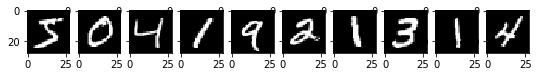

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,10,figsize=(9,3))
for i in range(10):
    axes[i].imshow(X[i], cmap='gray')
plt.show()

### Make sure to shuffle

Shuffle before getting subsample or else we get mostly 0s,1s,2s etc...

In [5]:
subset = 10_000
idx = np.random.randint(0,n,size=subset)
X = X[idx,:,:]
y = y[idx]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n, w, h = X_train.shape

print(f"Using {n} images")

Using 8000 images


## RandomForestClassifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, \
    accuracy_score, confusion_matrix

In [8]:
rf = RandomForestClassifier(n_estimators=500,
                            min_samples_leaf=1,
                            oob_score=True, n_jobs=-1)
rf.fit(X_train.reshape(-1,w*h), y_train)
print("OOB", rf.oob_score_)

y_pred = rf.predict(X_test.reshape(-1, w*h))
conf = confusion_matrix(y_test, y_pred)
print(conf)
print("test accuracy", accuracy_score(y_test, y_pred))

OOB 0.952375
[[192   0   0   0   0   0   2   0   0   0]
 [  0 229   1   1   0   1   0   0   0   0]
 [  1   1 203   2   1   0   1   4   3   0]
 [  2   4   4 181   0   1   0   1   6   0]
 [  0   0   0   0 183   0   2   1   1  10]
 [  4   1   2   6   0 161   0   0   0   2]
 [  5   1   0   0   0   1 194   0   2   0]
 [  1   0   1   0   3   0   0 189   1   6]
 [  2   1   1   2   0   1   0   0 189   2]
 [  1   2   1   3   5   0   1   0   2 169]]
test accuracy 0.945


Conclusion is that a RF with only 500 trees does a quick easy job on this 8k image subsample. Does about what DL does with vanilla net. About 95% accurate.

With 48k training images and remaining 12 as test, we get .985 accuracy.

## Vanilla two-layers of 512 neurons, softmax on end

In [9]:
import tensorflow_addons as tfa
from keras.datasets import mnist
from tensorflow.keras import models, layers, callbacks, optimizers
import tqdm
from tqdm.keras import TqdmCallback

### Don't forget to normalize data for DL

In [10]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [11]:
num_classes = 10
layer1 = 512
layer2 = 512
batch_size = 2000
dropout = 0.2

model = models.Sequential()
model.add(layers.Dense(layer1, input_dim=w*h, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout))

model.add(layers.Dense(layer2, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout))

model.add(layers.Dense(num_classes, activation='softmax'))

In [16]:
# learning_rate = 0.15
# opt = optimizers.Adam(lr=learning_rate)
opt = optimizers.RMSprop() # this one seems a bit better

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

# callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train.reshape(n,w*h), y_train,
                    shuffle=True,
                    epochs=200,
                    validation_data=(X_test.reshape(-1,w*h), y_test),
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
                    )

In [13]:
y_pred = model.predict(X_test.reshape(-1,w*h))
y_pred = np.argmax(y_pred, axis=1)
val_accur = accuracy_score(y_test, y_pred)
print("Keras validation accuracy", val_accur)

conf = confusion_matrix(y_test, y_pred)
print(conf)

Keras validation accuracy 0.957
[[193   0   0   0   1   0   0   0   0   0]
 [  0 230   1   0   0   0   0   0   1   0]
 [  4   1 200   0   1   0   1   6   2   1]
 [  3   0   0 185   1   0   0   4   5   1]
 [  0   0   0   0 194   0   1   0   2   0]
 [  3   0   0   4   0 166   1   0   2   0]
 [  2   1   0   0   0   0 199   0   1   0]
 [  1   0   1   0   3   0   1 189   1   5]
 [  3   0   0   0   0   0   0   0 195   0]
 [  0   1   0   2  12   1   1   0   4 163]]


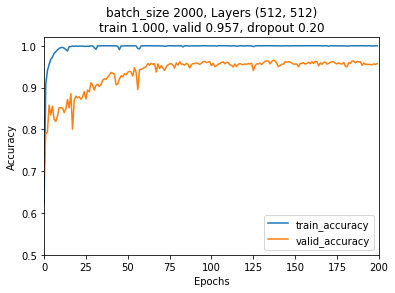

In [14]:
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

accur = history.history['accuracy']
plt.plot(accur, label='train_accuracy')
val_accur = history.history['val_accuracy']
plt.plot(val_accur, label='valid_accuracy')
plt.title(f"batch_size {batch_size}, Layers {layer1,layer2}\ntrain {accur[-1]:.3f}, valid {val_accur[-1]:.3f}, dropout {dropout:.2f}")
plt.xlim(0, 200)
plt.ylim(0.5, 1.02)
plt.legend(loc='lower right')
plt.show()

## Effect of data set size

With 1k not 8k records, RF and DL also seemed about the same with DL again a little ahead of RF, though slower and requiring more expertise to train.  Accur dropped from .95ish to .90ish for RF, but DL dropped to .85 (w/o changing architecture or tuning). Regardless, more training data helped both. As expected DL wants more data.  With only 100 images, RF drops to .6, but DL drops only to .7. Hmm...

Jumping to 16k records, RF is .97 and DL is almost .98.

With 48k training images and remaining 12 as test, RF gets .985 accuracy.  DL gets 0.9903! Almost perfect :)